# Tutorial: GEPA for Structured Information Extraction for Enterprise Tasks

In this tutorial, we'll explore a three-part task for structured information extraction and classification using the [Facility Support Analyzer](https://github.com/meta-llama/llama-prompt-ops/tree/main/use-cases/facility-support-analyzer) dataset released by Meta. Given an email or message sent in an enterprise setting related to facility maintenance or support requests, the goal is to extract its urgency, assess the sentiment, and identify all relevant service request categories.

We will build a simple DSPy program, and then use the `dspy.GEPA` optimizer to optimize it for the task.

<details>
<summary>Recommended: Set up MLflow Autologging to understand what's happening under the hood.</summary>

### MLflow DSPy Integration

<a href="https://mlflow.org/">MLflow</a> is an LLMOps tool that natively integrates with DSPy and offer explainability and experiment tracking. MLflow's autologging capability automatically tracks progress of GEPA optimization, as well as visualizes prompts and module executions as traces to understand the DSPy's behavior better. You can set up MLflow easily by following the four steps below.

**Visualize module executions as traces**

![MLflow Trace](./mlflow-tracing-gepa-support.png)

**Automatically track optimization progress and results**

![MLflow Tracking](./mlflow-tracking-gepa-support-optimization.png)


**Setup MLflow**

1. Install MLflow

```bash
%pip install mlflow>=3.0.0
```

2. Start MLflow UI in a separate terminal
```bash
mlflow ui --port 5000 --backend-store-uri sqlite:///mlruns.db
```

3. Connect the notebook to MLflow
```python
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("DSPy")
```

4. Enabling autologging.

```python
mlflow.dspy.autolog(
    # Log the optimization progress
    log_compiles=True,
    # Log the evaluation results
    log_evals=True,
    # Log traces from module executions
    log_traces=True
)
```


To learn more about the integration, visit [MLflow DSPy Documentation](https://mlflow.org/docs/latest/llms/dspy/index.html) as well.
</details>

### Setup the LM

We use GPT-4.1 nano to demonstrate how a small model can be tuned with GEPA.

In [1]:
api_key = input("Enter your OpenAI API key: ")
import dspy
lm = dspy.LM("openai/gpt-4.1-nano", temperature=1, api_key=api_key)
dspy.configure(lm=lm)

### Load the dataset

In [2]:
import requests
import dspy
import json
import random

def init_dataset():
    # Load from the url
    url = "https://raw.githubusercontent.com/meta-llama/llama-prompt-ops/refs/heads/main/use-cases/facility-support-analyzer/dataset.json"
    dataset = json.loads(requests.get(url).text)
    dspy_dataset = [
        dspy.Example({
            "message": d['fields']['input'],
            "answer": d['answer'],
        }).with_inputs("message")
        for d in dataset
    ]
    random.Random(0).shuffle(dspy_dataset)
    train_set = dspy_dataset[:int(len(dspy_dataset) * 0.33)]
    val_set = dspy_dataset[int(len(dspy_dataset) * 0.33):int(len(dspy_dataset) * 0.66)]
    test_set = dspy_dataset[int(len(dspy_dataset) * 0.66):]

    return train_set, val_set, test_set

In [3]:
train_set, val_set, test_set = init_dataset()

len(train_set), len(val_set), len(test_set)

(66, 66, 68)

Let's view an example task input

In [4]:
print("Input Message:")
print(train_set[0]['message'])

print("\n\nGold Answer:")
for k, v in json.loads(train_set[0]['answer']).items():
    print(f"{k}: {v}")

Input Message:
Subject: Adjusting Bi-Weekly Cleaning Schedule for My Office

Dear ProCare Facility Solutions Support Team,

I hope this message finds you well. My name is Dr. Alex Turner, and I have been utilizing your services for my office space for the past year. I must say, your team's dedication to maintaining a pristine environment has been commendable and greatly appreciated.

I am reaching out to discuss the scheduling of our regular cleaning services. While I find the logistical challenges of coordinating these services intellectually stimulating, I believe we could optimize the current schedule to better suit the needs of my team and our workflow. Specifically, I would like to explore the possibility of adjusting our cleaning schedule to a bi-weekly arrangement, ideally on Tuesdays and Fridays, to ensure our workspace remains consistently clean without disrupting our research activities.

Previously, I have attempted to adjust the schedule through the online portal, but I enc

### Defining a DSPy program to solve the task
The program is a 3-module system, each of which handles the urgency, sentiment and categories classification respectively

In [5]:
from typing import List, Literal


class FacilitySupportAnalyzerUrgency(dspy.Signature):
    """
    Read the provided message and determine the urgency.
    """
    message: str = dspy.InputField()
    urgency: Literal['low', 'medium', 'high'] = dspy.OutputField()

class FacilitySupportAnalyzerSentiment(dspy.Signature):
    """
    Read the provided message and determine the sentiment.
    """
    message: str = dspy.InputField()
    sentiment: Literal['positive', 'neutral', 'negative'] = dspy.OutputField()

class FacilitySupportAnalyzerCategories(dspy.Signature):
    """
    Read the provided message and determine the set of categories applicable to the message.
    """
    message: str = dspy.InputField()
    categories: List[Literal["emergency_repair_services", "routine_maintenance_requests", "quality_and_safety_concerns", "specialized_cleaning_services", "general_inquiries", "sustainability_and_environmental_practices", "training_and_support_requests", "cleaning_services_scheduling", "customer_feedback_and_complaints", "facility_management_issues"]] = dspy.OutputField()

class FacilitySupportAnalyzerMM(dspy.Module):
    def __init__(self):
        self.urgency_module = dspy.ChainOfThought(FacilitySupportAnalyzerUrgency)
        self.sentiment_module = dspy.ChainOfThought(FacilitySupportAnalyzerSentiment)
        self.categories_module = dspy.ChainOfThought(FacilitySupportAnalyzerCategories)
    
    def forward(self, message: str):
        urgency = self.urgency_module(message=message)
        sentiment = self.sentiment_module(message=message)
        categories = self.categories_module(message=message)

        return dspy.Prediction(
            urgency=urgency.urgency,
            sentiment=sentiment.sentiment,
            categories=categories.categories
        )

program = FacilitySupportAnalyzerMM()

### Define the metric to evaluate the outputs
The metric evaluates the output of all the three tasks, and returns the aggregate score

In [6]:
def score_urgency(gold_urgency, pred_urgency):
    """
    Compute score for the urgency module.
    """
    score = 1.0 if gold_urgency == pred_urgency else 0.0
    return score

def score_sentiment(gold_sentiment, pred_sentiment):
    """
    Compute score for the sentiment module.
    """
    score = 1.0 if gold_sentiment == pred_sentiment else 0.0
    return score

def score_categories(gold_categories, pred_categories):
    """
    Compute score for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correct = 0
    for k, v in gold_categories.items():
        if v and k in pred_categories:
            correct += 1
        elif not v and k not in pred_categories:
            correct += 1
    score = correct / len(gold_categories)
    return score

def metric(example, pred, trace=None, pred_name=None, pred_trace=None):
    """
    Computes a score based on agreement between prediction and gold standard for categories, sentiment, and urgency.
    Returns the score (float).
    """
    # Parse gold standard from example
    gold = json.loads(example['answer'])

    # Compute scores for all modules
    score_urgency_val = score_urgency(gold['urgency'], pred.urgency)
    score_sentiment_val = score_sentiment(gold['sentiment'], pred.sentiment)
    score_categories_val = score_categories(gold['categories'], pred.categories)

    # Overall score: average of the three accuracies
    total = (score_urgency_val + score_sentiment_val + score_categories_val) / 3

    return total

### Evaluating the unoptimized program (running with GPT-4.1 nano)

In [7]:
import dspy
evaluate = dspy.Evaluate(
    devset=test_set,
    metric=metric,
    num_threads=32,
    display_table=True,
    display_progress=True
)

evaluate(program)

Average Metric: 51.30 / 68 (75.4%): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 322.00it/s]

2025/08/12 18:09:18 INFO dspy.evaluate.evaluate: Average Metric: 51.3 / 68 (75.4%)


,message,answer,urgency,sentiment,categories,metric
0,"Hey ProCare Support Team, Hope you all are doing great! My name is...","{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,positive,[sustainability_and_environmental_practices],✔️ [1.000]
1,"Hey ProCare Team, Hope you’re all doing well! My name’s Jake, and ...","{""categories"": {""routine_maintenance_requests"": true, ""customer_fe...",medium,positive,"[routine_maintenance_requests, customer_feedback_and_complaints]",✔️ [0.967]
2,"Subject: Assistance Needed for HVAC Maintenance Hi [Receiver], I h...","{""categories"": {""routine_maintenance_requests"": true, ""customer_fe...",medium,neutral,[routine_maintenance_requests],✔️ [1.000]
3,Subject: A Green Inquiry from a Bill Maher Enthusiast Hey ProCare ...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,positive,[sustainability_and_environmental_practices],✔️ [1.000]
4,Subject: Inquiry on Sustainability Practices Dear ProCare Facility...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",medium,neutral,[sustainability_and_environmental_practices],✔️ [0.667]
...,...,...,...,...,...,...
63,Subject: Inquiry About Your Eco-Friendly Practices Dear ProCare Fa...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",medium,neutral,[sustainability_and_environmental_practices],✔️ [0.600]
64,Subject: Assistance Needed for Facility Management Issue Dear ProC...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",high,positive,[facility_management_issues],✔️ [0.667]
65,"Subject: Request for Training and Support Hi ProCare Support Team,...","{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,positive,[training_and_support_requests],✔️ [1.000]
66,Subject: Concerns About Studio Maintenance and Rent Increase Dear ...,"{""categories"": {""routine_maintenance_requests"": true, ""customer_fe...",medium,negative,"[routine_maintenance_requests, facility_management_issues]",✔️ [0.600]


EvaluationResult(score=75.44, results=<list of 68 results>)

### Optimizing with GEPA

GEPA is a _reflective_ prompt optimizer. Its strength lies in its ability to examine textual feedback from the DSPy program's execution and evaluation pipelines. This gives GEPA greater insight into why the system achieved a particular score, enabling it to introspect and determine ways to enhance performance.

In this scenario, the final score is based on performance across three distinct tasks. It's straightforward to see that each predictor handles a specific part of the overall score.

GEPA supports providing feedback at the individual predictor level (though this isn't required—see the GEPA PAPILLON tutorial for an example without it). Let's make a quick adjustment to our evaluation metric, to make it an optimization metric, that also provides text feedback!

In [8]:
import json
import dspy

def feedback_urgency(gold_urgency, pred_urgency):
    """
    Generate feedback for the urgency module.
    """
    score = 1.0 if gold_urgency == pred_urgency else 0.0
    if gold_urgency == pred_urgency:
        feedback = f"You correctly classified the urgency of the message as `{gold_urgency}`. This message is indeed of `{gold_urgency}` urgency."
    else:
        feedback = f"You incorrectly classified the urgency of the message as `{pred_urgency}`. The correct urgency is `{gold_urgency}`. Think about how you could have reasoned to get the correct urgency label."
    return feedback, score

def feedback_sentiment(gold_sentiment, pred_sentiment):
    """
    Generate feedback for the sentiment module.
    """
    score = 1.0 if gold_sentiment == pred_sentiment else 0.0
    if gold_sentiment == pred_sentiment:
        feedback = f"You correctly classified the sentiment of the message as `{gold_sentiment}`. This message is indeed `{gold_sentiment}`."
    else:
        feedback = f"You incorrectly classified the sentiment of the message as `{pred_sentiment}`. The correct sentiment is `{gold_sentiment}`. Think about how you could have reasoned to get the correct sentiment label."
    return feedback, score

def feedback_categories(gold_categories, pred_categories):
    """
    Generate feedback for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correctly_included = [k for k, v in gold_categories.items() if v and k in pred_categories]
    incorrectly_included = [k for k, v in gold_categories.items() if not v and k in pred_categories]
    incorrectly_excluded = [k for k, v in gold_categories.items() if v and k not in pred_categories]
    correctly_excluded = [k for k, v in gold_categories.items() if not v and k not in pred_categories]  # For completeness in accuracy check

    # Recompute category accuracy (matches score logic)
    score = (len(correctly_included) + len(correctly_excluded)) / len(gold_categories)

    if score == 1.0:
        fb_text = f"The category classification is perfect. You correctly identified that the message falls under the following categories: `{repr(correctly_included)}`."
    else:
        fb_text = f"The category classification is not perfect. You correctly identified that the message falls under the following categories: `{repr(correctly_included)}`.\n"
        if incorrectly_included:
            fb_text += f"However, you incorrectly identified that the message falls under the following categories: `{repr(incorrectly_included)}`. The message DOES NOT fall under these categories.\n"
        if incorrectly_excluded:
            prefix = "Additionally, " if incorrectly_included else "However, "
            fb_text += f"{prefix}you didn't identify the following categories that the message actually falls under: `{repr(incorrectly_excluded)}`.\n"
        fb_text += "Think about how you could have reasoned to get the correct category labels."
    return fb_text, score

def metric_with_feedback(example, pred, trace=None, pred_name=None, pred_trace=None):
    """
    Computes a score based on agreement between prediction and gold standard for categories, sentiment, and urgency.
    Optionally provides feedback text for a specific predictor module, using the same comparison logic as the score.
    Returns a dspy.Prediction with score (float) and feedback (str).
    """
    # Parse gold standard from example
    gold = json.loads(example['answer'])

    # Compute feedback and scores for all modules
    fb_urgency, score_urgency = feedback_urgency(gold['urgency'], pred.urgency)
    fb_sentiment, score_sentiment = feedback_sentiment(gold['sentiment'], pred.sentiment)
    fb_categories, score_categories = feedback_categories(gold['categories'], pred.categories)

    # Overall score: average of the three accuracies
    total = (score_urgency + score_sentiment + score_categories) / 3

    if pred_name is None:
        return total

    elif pred_name == 'urgency_module.predict':
        feedback = fb_urgency
    elif pred_name == 'sentiment_module.predict':
        feedback = fb_sentiment
    elif pred_name == 'categories_module.predict':
        feedback = fb_categories

    return dspy.Prediction(score=total, feedback=feedback)

Notice that the evaluation metric already contained all the information needed to generate the text feedback—we simply modified it to explicitly state what was being compared. In general, the metric functions for most tasks provide the essential components for creating such feedback; it often just requires identifying which elements to expose to the GEPA optimizer, enabling it to reflect on and enhance the program's performance.

Let's run GEPA

In [9]:
from dspy import GEPA

optimizer = GEPA(
    metric=metric_with_feedback,
    auto="light", # <-- We will use a light budget for this tutorial. However, we typically recommend using auto="heavy" for optimized performance!
    num_threads=32,
    track_stats=True,
    use_merge=False,
    reflection_lm=dspy.LM(model="gpt-5", temperature=1.0, max_tokens=32000, api_key=api_key)
)

In [10]:
optimized_program = optimizer.compile(
    program,
    trainset=train_set,
    valset=val_set,
)

2025/08/12 20:01:55 INFO dspy.teleprompt.gepa.gepa: Running GEPA for approx 1643 metric calls of the program. This amounts to 12.45 full evals on the train+val set.
2025/08/12 20:01:55 INFO dspy.teleprompt.gepa.gepa: Using 66 examples for tracking Pareto scores. You can consider using a smaller sample of the valset to allow GEPA to explore more diverse solutions within the same budget.
7
2025/08/12 20:01:56 INFO dspy.evaluate.evaluate: Average Metric: 47.56666666666666 / 66 (72.1%)
2025/08/12 20:01:56 INFO dspy.teleprompt.gepa.gepa: Iteration 0: Base program full valset score: 0.7207070707070706
2025/08/12 20:01:56 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Selected program 0 score: 0.7207070707070706
Average Metric: 2.27 / 3 (75.6%): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 83.95it/s]
2025/08/12 20:01:56 INFO dspy.evaluate.evaluate: Average Metric: 2.2666666666666666 / 3 (75.6%)
2025/08/12 20:0

### Let's take a look at the optimized prompts

In [11]:
for name, pred in optimized_program.named_predictors():
    print("================================")
    print(f"Predictor: {name}")
    print("================================")
    print("Prompt:")
    print(pred.signature.instructions)
    print("*********************************")

Predictor: urgency_module.predict
Prompt:
Task: Read the provided message and determine the urgency.

Context/domain:
- Messages typically relate to facility management and services (e.g., facility operations, space utilization, security, sustainability, HVAC systems, maintenance, cleaning services) for a provider like ProCare Facility Solutions.
- Senders may be residential or commercial clients and may reference residents, tenants, property operations, or prior support interactions.

Output format:
- Provide exactly two fields, in this order, no extra text or formatting:
reasoning: <1–3 concise sentences explaining the key cues that determine urgency>
urgency: <one of: low | medium | high>

Urgency levels and decision rules:
- HIGH:
  - Clear or implied immediate risk to safety/security or major operational impact.
  - Explicit urgency signals (e.g., “Urgent,” “Immediate attention required,” “ASAP,” “critical,” “escalating”).
  - Severe dissatisfaction with demand for immediate corre

Note the high levels of detail about the task learnt in the prompts!

### Now, let's evaluate the optimized program

In [12]:
evaluate(optimized_program)

Average Metric: 59.17 / 68 (87.0%): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:06<00:00, 11.02it/s]

2025/08/12 20:57:09 INFO dspy.evaluate.evaluate: Average Metric: 59.166666666666664 / 68 (87.0%)


,message,answer,urgency,sentiment,categories,metric
0,"Hey ProCare Support Team, Hope you all are doing great! My name is...","{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,positive,[sustainability_and_environmental_practices],✔️ [1.000]
1,"Hey ProCare Team, Hope you’re all doing well! My name’s Jake, and ...","{""categories"": {""routine_maintenance_requests"": true, ""customer_fe...",medium,positive,[routine_maintenance_requests],✔️ [1.000]
2,"Subject: Assistance Needed for HVAC Maintenance Hi [Receiver], I h...","{""categories"": {""routine_maintenance_requests"": true, ""customer_fe...",medium,neutral,[routine_maintenance_requests],✔️ [1.000]
3,Subject: A Green Inquiry from a Bill Maher Enthusiast Hey ProCare ...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,positive,[sustainability_and_environmental_practices],✔️ [1.000]
4,Subject: Inquiry on Sustainability Practices Dear ProCare Facility...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,neutral,[sustainability_and_environmental_practices],✔️ [1.000]
...,...,...,...,...,...,...
63,Subject: Inquiry About Your Eco-Friendly Practices Dear ProCare Fa...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,neutral,[sustainability_and_environmental_practices],✔️ [0.933]
64,Subject: Assistance Needed for Facility Management Issue Dear ProC...,"{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",medium,neutral,[facility_management_issues],✔️ [0.667]
65,"Subject: Request for Training and Support Hi ProCare Support Team,...","{""categories"": {""routine_maintenance_requests"": false, ""customer_f...",low,neutral,[training_and_support_requests],✔️ [0.667]
66,Subject: Concerns About Studio Maintenance and Rent Increase Dear ...,"{""categories"": {""routine_maintenance_requests"": true, ""customer_fe...",medium,neutral,"[routine_maintenance_requests, facility_management_issues]",✔️ [0.933]


EvaluationResult(score=87.01, results=<list of 68 results>)

GEPA was able to optimize GPT-4.1 nano's performance **from 75% score to 87%** in the auto="light" setting.

### Bonus: Detailed Results

A GEPA run with `track_stats=True` returns detailed results in the `detailed_results` attribute.

- **candidates**: List of proposed candidates.
- **parents**: For each candidate, list of parent indices or None.
- **val_aggregate_scores**: Aggregate validation score per candidate.
- **val_subscores**: Per-instance validation scores per candidate.
- **per_val_instance_best_candidates**: Indices of best candidates for each validation instance
- **discovery_eval_counts**: Metric calls/rollouts used to discover each candidate.
- **best_outputs_valset**: Best output produced for each task (only present with `track_best_outputs=True`)
- **best_idx**: Index of candidate with top score.
- **best_candidate**: Program for best_idx.

Let's visualize the optimization trajectory taken by GEPA for this task.


Specifically, we can access the `parents` attribute, which identifies the parent programs for each candidate program. We use a simple script to plot these as a Graphviz DOT visualization, which can be rendered locally using Graphviz or through online tools like [GraphvizOnline](https://is.gd/meuHtO).

In [13]:
def dag_to_dot(parent_program_for_candidate, dominator_program_ids, best_program_idx, full_eval_scores):
    dot_lines = [
        "digraph G {",
        "    node [style=filled, shape=circle, fontsize=50];"
    ]
    n = len(parent_program_for_candidate)
    # Set up nodes with colors and scores in labels
    for idx in range(n):
        score = full_eval_scores[idx]
        label = f"{idx}\\n({score:.2f})"
        if idx == best_program_idx:
            dot_lines.append(f'    {idx} [label="{label}", fillcolor=cyan, fontcolor=black];')
        elif idx in dominator_program_ids:
            dot_lines.append(f'    {idx} [label="{label}", fillcolor=orange, fontcolor=black];')
        else:
            dot_lines.append(f'    {idx} [label="{label}"];')
    
    # Set up edges
    for child, parents in enumerate(parent_program_for_candidate):
        for parent in parents:
            if parent is not None:
                dot_lines.append(f'    {parent} -> {child};')
    
    dot_lines.append("}")
    return "\n".join(dot_lines)

from gepa.gepa_utils import find_dominator_programs
pareto_front_programs = find_dominator_programs(optimized_program.detailed_results.per_val_instance_best_candidates, optimized_program.detailed_results.val_aggregate_scores)

print(dag_to_dot(
    optimized_program.detailed_results.parents,
    pareto_front_programs,
    optimized_program.detailed_results.best_idx,
    optimized_program.detailed_results.val_aggregate_scores
))

digraph G {
    node [style=filled, shape=circle, fontsize=50];
    0 [label="0\n(0.72)"];
    1 [label="1\n(0.71)"];
    2 [label="2\n(0.79)"];
    3 [label="3\n(0.86)"];
    4 [label="4\n(0.86)", fillcolor=orange, fontcolor=black];
    5 [label="5\n(0.81)"];
    6 [label="6\n(0.80)"];
    7 [label="7\n(0.83)"];
    8 [label="8\n(0.86)", fillcolor=orange, fontcolor=black];
    9 [label="9\n(0.83)", fillcolor=orange, fontcolor=black];
    10 [label="10\n(0.76)"];
    11 [label="11\n(0.83)"];
    12 [label="12\n(0.77)", fillcolor=orange, fontcolor=black];
    13 [label="13\n(0.84)", fillcolor=orange, fontcolor=black];
    14 [label="14\n(0.83)"];
    15 [label="15\n(0.81)", fillcolor=orange, fontcolor=black];
    16 [label="16\n(0.78)"];
    17 [label="17\n(0.86)", fillcolor=cyan, fontcolor=black];
    18 [label="18\n(0.85)"];
    19 [label="19\n(0.74)", fillcolor=orange, fontcolor=black];
    20 [label="20\n(0.83)", fillcolor=orange, fontcolor=black];
    21 [label="21\n(0.77)", fillco

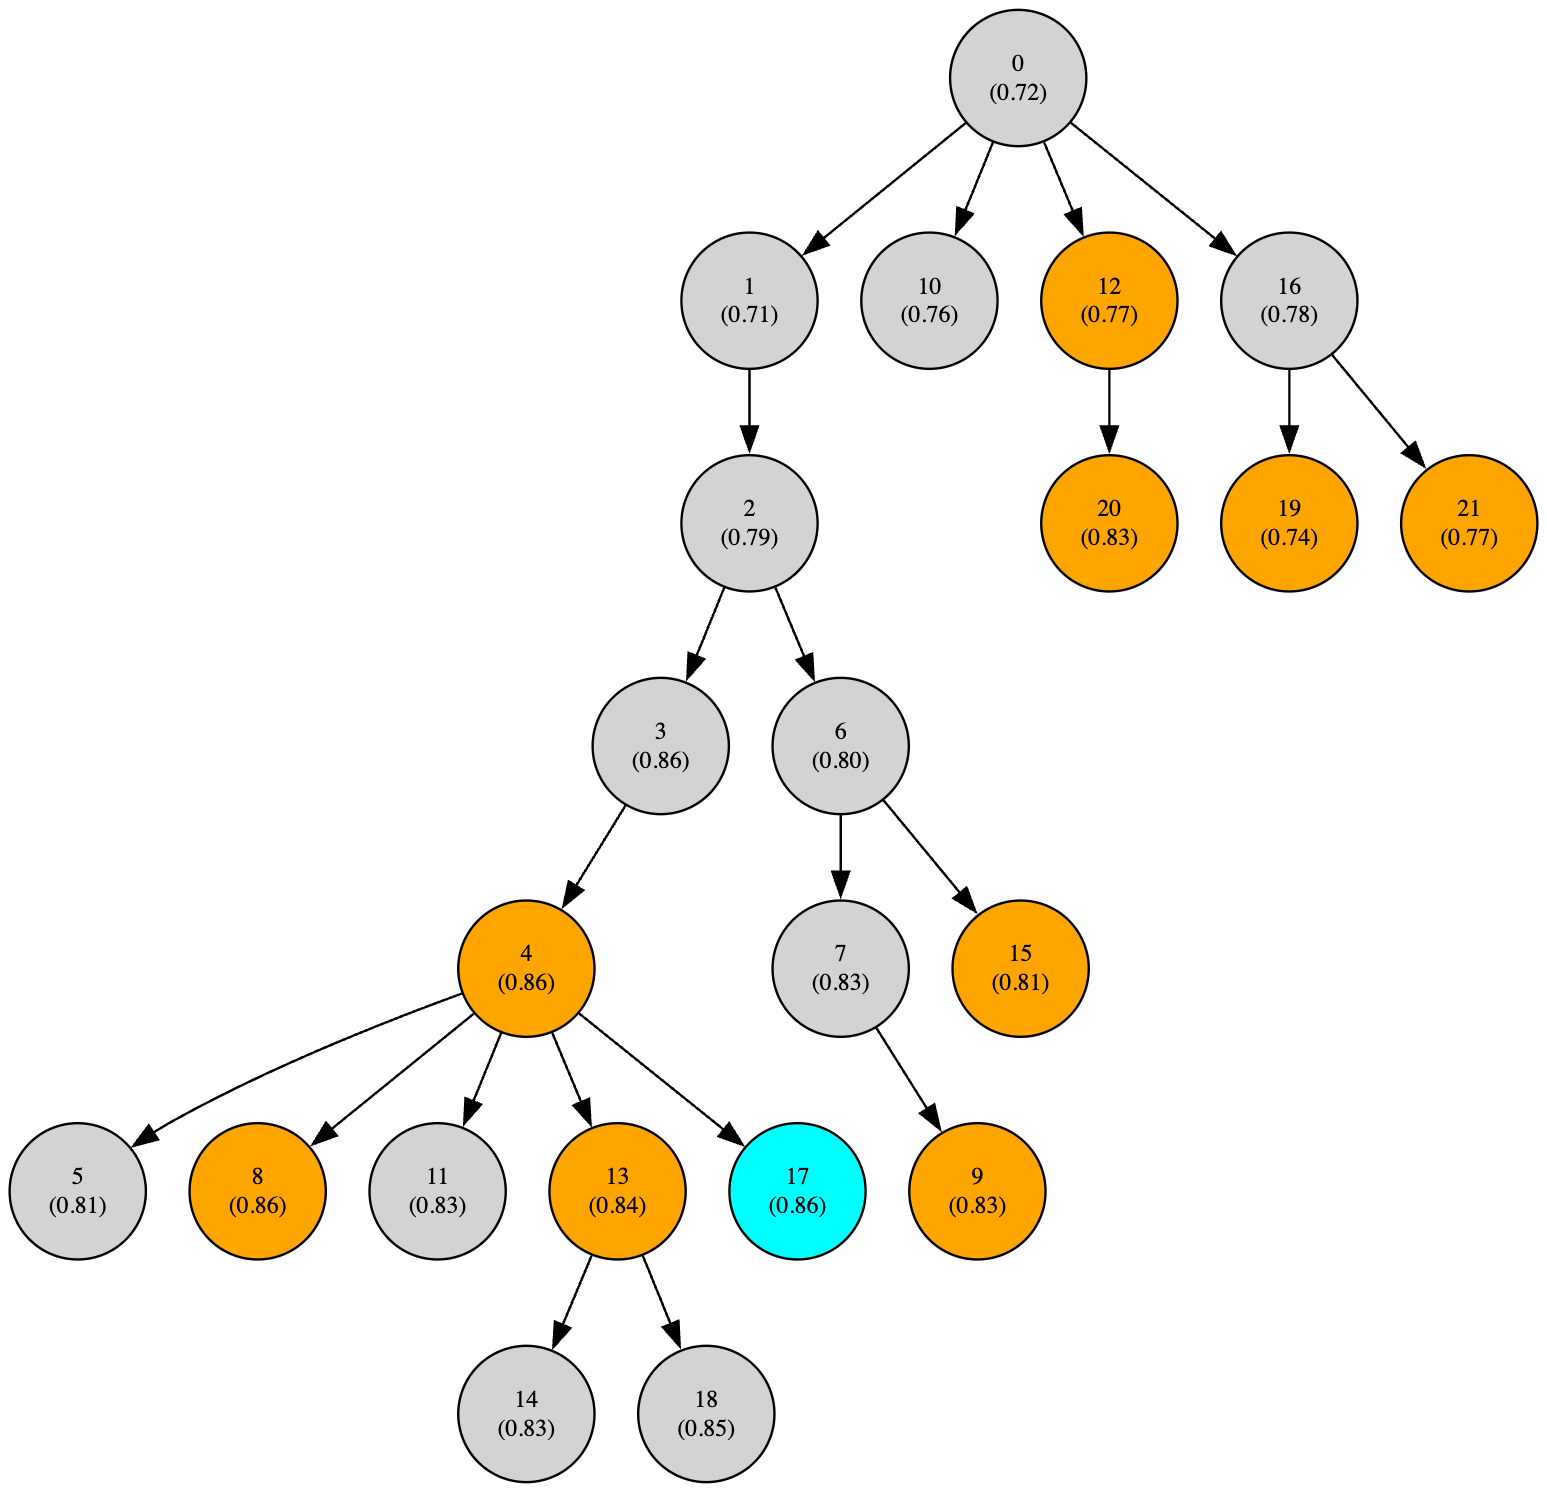